In [21]:
import sys
import time
import datetime
import os
import tensorflow as tf
import argparse
import json
import socket
from PIL import Image
from util import *
import numpy as np
%load_ext autoreload
%autoreload 2
from copy import deepcopy
from matplotlib import pyplot as plt
from matplotlib import image as mpimg
from matplotlib.colors import hsv_to_rgb
%matplotlib inline
from helpers import *
from datetime import datetime

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

with open("hyperParams.json") as f:
    instanceParams = json.load(f)

baseLearningRate = instanceParams["baseLR"]
learningRate = baseLearningRate

photoAlpha = instanceParams["photoParams"]["robustness"]
photoBeta = instanceParams["photoParams"]["scale"]
wei = instanceParams["smoothParams"]["weight"]

In [3]:
flow = np.zeros((480, 854, 2))
gt = mpimg.imread('../example_data/data/DAVIS/Annotations/480p/swing/00043.png')#np.zeros((480, 854))

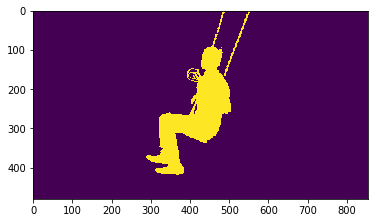

In [4]:
plt.imshow(gt)

In [5]:
flow = np.expand_dims(flow, 0)
gt = np.expand_dims(np.expand_dims(gt, 0), -1)

flow = tf.cast(flow, tf.float32)
gt = tf.cast(gt, tf.float32)
flow = tf.Variable(flow)

In [6]:
img0 = tf.image.decode_png(tf.read_file("../example_data/data/DAVIS/JPEGImages/480p/swing/00043.jpg"), channels=3, dtype=tf.uint8)
img1 = tf.image.decode_png(tf.read_file("../example_data/data/DAVIS/JPEGImages/480p/swing/00044.jpg"), channels=3, dtype=tf.uint8)

rgb0 = tf.cast(img0, tf.float32) - [[[[0,0,0]]]]
rgb1 = tf.cast(img1, tf.float32) - [[[[0,0,0]]]]

In [7]:
def mse_loss(f1, f2):
    return tf.reduce_sum(tf.square(f1 - f2), axis=-1, keep_dims=True)

In [8]:
kernel = tf.transpose(tf.constant([[[[0,-1,0],
                                     [0,1,0],
                                     [0,0,0]]],
                                   [[[0,0,0],
                                     [0,1,-1],
                                     [0,0,0]]],
                                   [[[0,0,0],
                                     [0,1,0],
                                     [0,-1,0]]],
                                   [[[0,0,0],
                                     [-1,1,0],
                                     [0,0,0]]]],
                                  dtype=tf.float32),perm=[3,2,1,0])

In [9]:
w = 1
GT_MASKS = []
for i in range(w):
    GT_MASKS.append(1 - tf.square(tf.nn.atrous_conv2d(gt, kernel, rate=i+1, padding='SAME')))

In [10]:
normalizer = tf.zeros((1, 480, 854, 2))

multiplier_masks = []
for i in range(w):
    multiplier_masks.append([])

for i in range(w):
    j = i + 1
    gt_mask = GT_MASKS[i]

    multiplier_masks[i].append(
        tf.tile(
            tf.expand_dims(
                tf.concat([gt_mask[:,:,j:854,0],
                           tf.zeros((1, 480, j), dtype=tf.float32)], axis=2), axis=-1), (1, 1, 1, 2)))

    multiplier_masks[i].append(
        tf.tile(
            tf.expand_dims(
                tf.concat([tf.zeros((1, j, 854), dtype=tf.float32),
                           gt_mask[:,0:(480-j),:,1]], axis=1), axis=-1), (1, 1, 1, 2)))

    multiplier_masks[i].append(
        tf.tile(
            tf.expand_dims(
                tf.concat([tf.zeros((1, 480, j), dtype=tf.float32),
                           gt_mask[:,:,0:(854-j),2]], axis=2), axis=-1), (1, 1, 1, 2)))

    multiplier_masks[i].append(
        tf.tile(
            tf.expand_dims(
                tf.concat([gt_mask[:,j:480,:,3],
                           tf.zeros((1, j, 854), dtype=tf.float32)], axis=1), axis=-1), (1, 1, 1, 2)))

    normalizer += multiplier_masks[i][0] + multiplier_masks[i][1] + multiplier_masks[i][2] + multiplier_masks[i][3]

# Remove 0's in normalizer
normalizer += 4 * w * tf.cast(tf.equal(normalizer, 0), dtype=tf.float32)
normalizer.shape

TensorShape([Dimension(1), Dimension(480), Dimension(854), Dimension(2)])

In [11]:
def fixed_point_update(flow, gamma, itr):
    flow_copy1 = flow * 1.0
    flow_copy2 = flow * 1.0
    flow_copy1 = tf.stop_gradient(flow_copy1)
    flow_copy2 = tf.stop_gradient(flow_copy2)

    for k in range(itr):
        temp = tf.zeros_like(flow)
        for i in range(w):
            j = i + 1
            temp += tf.concat([flow_copy1[:,:,j:854,:],
                               tf.zeros((1, 480, j, 2), dtype=tf.float32)], axis=2) * multiplier_masks[i][0]

            temp += tf.concat([tf.zeros((1, j, 854, 2), dtype=tf.float32),
                               flow_copy1[:,0:(480-j),:,:]], axis=1) * multiplier_masks[i][1]

            temp += tf.concat([tf.zeros((1, 480, j, 2), dtype=tf.float32),
                               flow_copy1[:,:,0:(854-j),:]], axis=2) * multiplier_masks[i][2]

            temp += tf.concat([flow_copy1[:,j:480,:,:],
                               tf.zeros((1, j, 854, 2), dtype=tf.float32)], axis=1) * multiplier_masks[i][3]

        temp += gamma * flow_copy2
        flow_copy1 = temp / (normalizer + gamma)
    return flow_copy1

In [12]:
def fixed_point_update(flow, gamma, itr):
    flow_copy1 = flow * 1.0
    flow_copy2 = flow * 1.0
    flow_copy1 = tf.stop_gradient(flow_copy1)
    flow_copy2 = tf.stop_gradient(flow_copy2)

    for k in range(itr):
        temp = tf.zeros_like(flow)
        for i in range(w):
            j = i + 1
            temp += tf.concat([flow_copy1[:,:,j:854,:],
                               tf.zeros((1, 480, j, 2), dtype=tf.float32)], axis=2) * multiplier_masks[i][0]

            temp += tf.concat([tf.zeros((1, j, 854, 2), dtype=tf.float32),
                               flow_copy1[:,0:(480-j),:,:]], axis=1) * multiplier_masks[i][1]

            temp += tf.concat([tf.zeros((1, 480, j, 2), dtype=tf.float32),
                               flow_copy1[:,:,0:(854-j),:]], axis=2) * multiplier_masks[i][2]

            temp += tf.concat([flow_copy1[:,j:480,:,:],
                               tf.zeros((1, j, 854, 2), dtype=tf.float32)], axis=1) * multiplier_masks[i][3]

        temp += gamma * flow_copy2
        flow_copy1 = temp / (normalizer + gamma)
    return flow_copy1

In [13]:
gammaTensor = tf.placeholder(tf.float32,shape=[])
golTensor = tf.placeholder(tf.float32,shape=[])
inner_itr = 10

def adm_loss_fn(flow, gol, gamma):
    pLoss = photoLoss(flow, rgb0, rgb1, photoAlpha, photoBeta)
    actual_smooth_loss = asymmetricSmoothLoss(flow, gt, instanceParams, 1, 1, None, instanceParams["boundaryAlpha"], True)
    actual_smooth_loss = tf.stop_gradient(actual_smooth_loss)
    fhat = fixed_point_update(flow, gol, inner_itr)
    sLoss = asymmetricSmoothLoss(fhat, gt, instanceParams, 1, 1, None, instanceParams["boundaryAlpha"], True)
    mLoss = mse_loss(flow, fhat)

    return pLoss, sLoss, gamma * mLoss, actual_smooth_loss, fhat

In [14]:
photo_loss, smooth_loss, eucl_loss, as_loss, fhat = adm_loss_fn(flow, golTensor, gammaTensor)
adm_loss = photo_loss + smooth_loss + eucl_loss

Instructions for updating:
keep_dims is deprecated, use keepdims instead


In [15]:
sGrad = tf.gradients(smooth_loss, fhat)
pGrad = tf.gradients(photo_loss, flow)
mGrad = tf.gradients(eucl_loss, flow)
tGrad = tf.gradients(adm_loss, flow)

In [16]:
momentum1 = 0.9
momentum2 = 0.999

def attach_SGD_Solver(loss):
    with tf.variable_scope(None,default_name="solver"):
        learningRate = tf.placeholder(tf.float32,shape=[])
        solver = tf.train.GradientDescentOptimizer(learning_rate=learningRate)
        solver_op = solver.minimize(loss)
        return [solver, solver_op, learningRate]
    
def attach_ADAM_Solver(loss):
    with tf.variable_scope(None,default_name="solver"):
        learningRate = tf.placeholder(tf.float32,shape=[])
        solver = tf.train.AdamOptimizer(learning_rate=learningRate , beta1=momentum1, beta2=momentum2)
        solver_op = solver.minimize(loss)
        return [solver, solver_op, learningRate]

In [17]:
solver, solver_op, learningRateTensor = attach_SGD_Solver(adm_loss)

In [32]:
itr = 9000

In [ ]:
init = tf.global_variables_initializer()
mLosses, sLosses, pLosses, asLosses = [], [], [], []
tGrads, sGrads, pGrads, mGrads = [], [], [], []
flows, flow_props = [], []

print_freq = 10
with tf.Session() as sess:
    sess.run(init)
    for i in range(1, itr + 2):
        feed_dict = {
            learningRateTensor: 5e-5,
            gammaTensor: 1000 * 4 * 4,
            golTensor: 4
        }
        _, s, p, m, f, fp, asl, mg = sess.run([solver_op,
                                      smooth_loss,
                                      photo_loss,
                                      eucl_loss,
                                      flow,
                                      fhat,
                                      as_loss,
                                      mGrad], feed_dict = feed_dict)

        if i % print_freq == 1:
            print(i)
            flows.append(deepcopy(f[0]))
            flow_props.append(deepcopy(fp[0]))
            sLosses.append(np.mean(s))
            pLosses.append(np.mean(p))
            mLosses.append(np.mean(m))
            asLosses.append(np.mean(asl))
            mGrads.append(np.median(np.abs(mg[0])))
            print "Photo loss: %f" % pLosses[-1]
            print "Smooth loss after fixed point update: %f" % sLosses[-1]
            print "Smooth loss from network: %f" % asLosses[-1]

1
Photo loss: 4052.045654
Smooth loss after fixed point update: 0.000004
Smooth loss from network: 0.000004
11
Photo loss: 3174.023682
Smooth loss after fixed point update: 0.049857
Smooth loss from network: 0.101831
21
Photo loss: 2994.604492
Smooth loss after fixed point update: 0.061305
Smooth loss from network: 0.111525
31
Photo loss: 2880.357422
Smooth loss after fixed point update: 0.068860
Smooth loss from network: 0.118053
41
Photo loss: 2802.698730
Smooth loss after fixed point update: 0.074698
Smooth loss from network: 0.124675
51
Photo loss: 2738.259277
Smooth loss after fixed point update: 0.078892
Smooth loss from network: 0.128180
61
Photo loss: 2683.991943
Smooth loss after fixed point update: 0.082518
Smooth loss from network: 0.131527
71
Photo loss: 2641.459717
Smooth loss after fixed point update: 0.084830
Smooth loss from network: 0.132559
81
Photo loss: 2600.430420
Smooth loss after fixed point update: 0.087427
Smooth loss from network: 0.135523
91
Photo loss: 2568.

761
Photo loss: 1960.869629
Smooth loss after fixed point update: 0.120097
Smooth loss from network: 0.163158
771
Photo loss: 1959.626221
Smooth loss after fixed point update: 0.119983
Smooth loss from network: 0.162408
781
Photo loss: 1956.400146
Smooth loss after fixed point update: 0.120256
Smooth loss from network: 0.163642
791
Photo loss: 1954.200195
Smooth loss after fixed point update: 0.120227
Smooth loss from network: 0.163215
801
Photo loss: 1950.491333
Smooth loss after fixed point update: 0.120403
Smooth loss from network: 0.163459
811
Photo loss: 1947.439331
Smooth loss after fixed point update: 0.120269
Smooth loss from network: 0.162724
821
Photo loss: 1943.329224
Smooth loss after fixed point update: 0.120456
Smooth loss from network: 0.162847
831
Photo loss: 1940.209229
Smooth loss after fixed point update: 0.120689
Smooth loss from network: 0.163515
841
Photo loss: 1939.145996
Smooth loss after fixed point update: 0.121005
Smooth loss from network: 0.164271
851
Photo 

1521
Photo loss: 1827.794189
Smooth loss after fixed point update: 0.123875
Smooth loss from network: 0.164640
1531
Photo loss: 1826.931885
Smooth loss after fixed point update: 0.123861
Smooth loss from network: 0.164482
1541
Photo loss: 1825.007324
Smooth loss after fixed point update: 0.124209
Smooth loss from network: 0.165759
1551
Photo loss: 1823.409180
Smooth loss after fixed point update: 0.123961
Smooth loss from network: 0.164580
1561
Photo loss: 1822.563721
Smooth loss after fixed point update: 0.124133
Smooth loss from network: 0.165281
1571
Photo loss: 1820.968018
Smooth loss after fixed point update: 0.124101
Smooth loss from network: 0.164997
1581
Photo loss: 1819.905396
Smooth loss after fixed point update: 0.124241
Smooth loss from network: 0.165360
1591
Photo loss: 1818.102417
Smooth loss after fixed point update: 0.124104
Smooth loss from network: 0.164911
1601
Photo loss: 1818.106323
Smooth loss after fixed point update: 0.124160
Smooth loss from network: 0.165040
1

2261
Photo loss: 1770.545410
Smooth loss after fixed point update: 0.124430
Smooth loss from network: 0.164394
2271
Photo loss: 1769.330688
Smooth loss after fixed point update: 0.124713
Smooth loss from network: 0.165396
2281
Photo loss: 1768.046265
Smooth loss after fixed point update: 0.124516
Smooth loss from network: 0.164725
2291
Photo loss: 1767.487061
Smooth loss after fixed point update: 0.124608
Smooth loss from network: 0.164392
2301
Photo loss: 1766.589233
Smooth loss after fixed point update: 0.124631
Smooth loss from network: 0.164642
2311
Photo loss: 1765.796143
Smooth loss after fixed point update: 0.124609
Smooth loss from network: 0.164841
2321
Photo loss: 1764.932129
Smooth loss after fixed point update: 0.124680
Smooth loss from network: 0.164754
2331
Photo loss: 1764.411377
Smooth loss after fixed point update: 0.124563
Smooth loss from network: 0.164141
2341
Photo loss: 1762.688477
Smooth loss after fixed point update: 0.124726
Smooth loss from network: 0.164534
2

3001
Photo loss: 1732.104736
Smooth loss after fixed point update: 0.125041
Smooth loss from network: 0.164793
3011
Photo loss: 1731.703247
Smooth loss after fixed point update: 0.124899
Smooth loss from network: 0.164017
3021
Photo loss: 1731.685547
Smooth loss after fixed point update: 0.124896
Smooth loss from network: 0.164329
3031
Photo loss: 1729.720581
Smooth loss after fixed point update: 0.125027
Smooth loss from network: 0.164580
3041
Photo loss: 1730.160156
Smooth loss after fixed point update: 0.124936
Smooth loss from network: 0.164329
3051
Photo loss: 1729.743042
Smooth loss after fixed point update: 0.125012
Smooth loss from network: 0.164596
3061
Photo loss: 1729.243286
Smooth loss after fixed point update: 0.125080
Smooth loss from network: 0.164738
3071
Photo loss: 1728.898682
Smooth loss after fixed point update: 0.125208
Smooth loss from network: 0.165235
3081
Photo loss: 1727.634155
Smooth loss after fixed point update: 0.125346
Smooth loss from network: 0.165572
3

3741
Photo loss: 1690.748169
Smooth loss after fixed point update: 0.126510
Smooth loss from network: 0.165460
3751
Photo loss: 1688.791748
Smooth loss after fixed point update: 0.126575
Smooth loss from network: 0.165610
3761
Photo loss: 1688.744751
Smooth loss after fixed point update: 0.126722
Smooth loss from network: 0.166528
3771
Photo loss: 1689.806519
Smooth loss after fixed point update: 0.126517
Smooth loss from network: 0.165450
3781
Photo loss: 1688.595337
Smooth loss after fixed point update: 0.126591
Smooth loss from network: 0.165617
3791
Photo loss: 1688.259277
Smooth loss after fixed point update: 0.126623
Smooth loss from network: 0.165764
3801
Photo loss: 1687.360352
Smooth loss after fixed point update: 0.126494
Smooth loss from network: 0.165123
3811
Photo loss: 1686.895386
Smooth loss after fixed point update: 0.126716
Smooth loss from network: 0.165878
3821
Photo loss: 1686.641479
Smooth loss after fixed point update: 0.126747
Smooth loss from network: 0.166216
3

4481
Photo loss: 1672.708862
Smooth loss after fixed point update: 0.126916
Smooth loss from network: 0.165890
4491
Photo loss: 1672.987671
Smooth loss after fixed point update: 0.126926
Smooth loss from network: 0.165663
4501
Photo loss: 1672.469849
Smooth loss after fixed point update: 0.127154
Smooth loss from network: 0.166980
4511
Photo loss: 1673.215332
Smooth loss after fixed point update: 0.126949
Smooth loss from network: 0.166181
4521
Photo loss: 1672.388794
Smooth loss after fixed point update: 0.126940
Smooth loss from network: 0.166066
4531
Photo loss: 1671.512573
Smooth loss after fixed point update: 0.126959
Smooth loss from network: 0.165975
4541
Photo loss: 1671.561646
Smooth loss after fixed point update: 0.126860
Smooth loss from network: 0.165839
4551
Photo loss: 1671.820312
Smooth loss after fixed point update: 0.126747
Smooth loss from network: 0.165095
4561
Photo loss: 1671.910400
Smooth loss after fixed point update: 0.127012
Smooth loss from network: 0.166381
4

5221
Photo loss: 1656.082153
Smooth loss after fixed point update: 0.126634
Smooth loss from network: 0.165499
5231
Photo loss: 1653.809814
Smooth loss after fixed point update: 0.126963
Smooth loss from network: 0.166294
5241
Photo loss: 1654.952515
Smooth loss after fixed point update: 0.126789
Smooth loss from network: 0.166043
5251
Photo loss: 1654.522827
Smooth loss after fixed point update: 0.126591
Smooth loss from network: 0.165264
5261
Photo loss: 1654.145386
Smooth loss after fixed point update: 0.126705
Smooth loss from network: 0.165644
5271
Photo loss: 1653.654297
Smooth loss after fixed point update: 0.126701
Smooth loss from network: 0.165299
5281
Photo loss: 1653.006104
Smooth loss after fixed point update: 0.126561
Smooth loss from network: 0.165139
5291
Photo loss: 1653.698975
Smooth loss after fixed point update: 0.126467
Smooth loss from network: 0.164901
5301
Photo loss: 1653.545532
Smooth loss after fixed point update: 0.126698
Smooth loss from network: 0.165873
5

5961
Photo loss: 1645.203491
Smooth loss after fixed point update: 0.126693
Smooth loss from network: 0.165463
5971
Photo loss: 1645.173828
Smooth loss after fixed point update: 0.126739
Smooth loss from network: 0.165449
5981
Photo loss: 1645.101440
Smooth loss after fixed point update: 0.126656
Smooth loss from network: 0.165195
5991
Photo loss: 1645.740967
Smooth loss after fixed point update: 0.126868
Smooth loss from network: 0.165769
6001
Photo loss: 1645.715576
Smooth loss after fixed point update: 0.126640
Smooth loss from network: 0.164944
6011
Photo loss: 1646.180786
Smooth loss after fixed point update: 0.126833
Smooth loss from network: 0.165990
6021
Photo loss: 1646.010986
Smooth loss after fixed point update: 0.126777
Smooth loss from network: 0.165679
6031
Photo loss: 1645.429688
Smooth loss after fixed point update: 0.126654
Smooth loss from network: 0.165258
6041
Photo loss: 1644.854126
Smooth loss after fixed point update: 0.126628
Smooth loss from network: 0.165297
6

In [29]:
mLosses = np.array(mLosses)
sLosses = np.array(sLosses)
pLosses = np.array(pLosses)
tLosses = pLosses + mLosses
asLosses = np.array(asLosses)

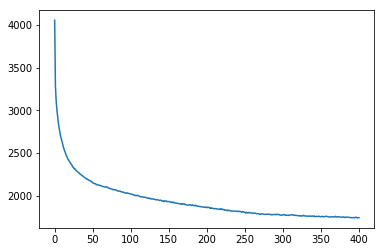

In [30]:
total_loss = (pLosses + 1000 * asLosses)
plt.plot(total_loss)

In [31]:
# np.save("split_swing_sgd_lambda10k", total_loss)
# np.save("split_swing_adam_lambda10k", total_loss)
np.save("split_swing_sgd_lambda1k", total_loss)
# np.save("split_swing_adam_lambda1k", total_loss)